In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from funcshape.testlib.curves import Infinity, LogStepDiff
from funcshape.transforms import Qmap1D, SRVT, Qmap2D
from funcshape.reparametrize import reparametrize
from funcshape.layers.sineseries import SineSeries
from funcshape.layers.sinefourier import SineFourierLayer
from funcshape.networks import CurveReparametrizer, SurfaceReparametrizer
from funcshape.loss import CurveDistance, SurfaceDistance
from funcshape.logging import Silent
from funcshape.visual import create_figsaver, MONOCHROME

import torch
import matplotlib.pyplot as plt

In [3]:
def curve_reparametrization(c1, c2, num_layers, num_functions, transform="qmap", k=256, max_iter=200, device="cuda",
                            **kwargs):
    print(f"Layers: {num_layers:4d}, functions: {num_functions:3d}\r", end="")
    if device == "cuda":
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if device == "cpu": raise RuntimeError("cuda not available")
    if transform.lower() == "qmap":
        q, r = Qmap1D(c1), Qmap1D(c2)
    elif transform.lower() == "srvt":
        q, r = SRVT(c1), SRVT(c2)
    else:
        raise ValueError("Transform should be 'qmap' or 'srvt'")

    RN = CurveReparametrizer(
        [SineSeries(num_functions) for _ in range(num_layers)]
    )
    optimizer = torch.optim.LBFGS(RN.parameters(), max_iter=max_iter,
                                  line_search_fn="strong_wolfe")
    loss = CurveDistance(q, r, k=k)
    error = reparametrize(RN, loss, optimizer, 1, **kwargs)
    RN.to("cpu"), loss.to("cpu"); # Need on CPU for plotting.
    return error[-1]

In [4]:
def surface_reparametrization(c1, c2, num_layers, num_functions, transform="qmap", k=32, max_iter=200, device="cpu", **kwargs):
    print(f"Layers: {num_layers:4d}, functions: {num_functions:3d}\r", end="")
    if device == "cuda":
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if device == "cpu": raise RuntimeError("cuda not available")
            
    if transform.lower() == "qmap":
        q, r = Qmap2D(c1), Qmap2D(c2)
    elif transform.lower() == "SRNF":
        q, r = SRNF(c1), SRNF(c2)
    else:
        raise ValueError("Transform should be 'qmap' or 'srvt'")

    RN = SurfaceReparametrizer(
        [SineFourierLayer(num_functions) for _ in range(num_layers)]
    ).to(device)
    optimizer = torch.optim.LBFGS(RN.parameters(), max_iter=max_iter,
                                  line_search_fn="strong_wolfe")
    loss = SurfaceDistance(q, r, k=k).to(device)
    error = reparametrize(RN, loss, optimizer, 1, **kwargs)
    RN.to("cpu"), loss.to("cpu"); # Need on CPU for plotting.
    return error[-1]


def create_convergence_dict(c0, c1, num_layers, num_functions, reparam_wrapper, **kwargs):
    return {
        i: {
            j: reparam_wrapper(c0, c1, i, j, **kwargs) for j in num_functions
        }
        for i in num_layers
    }


In [5]:
def plot_depth_convergence(d, ax=None, subset=None, log=True, label_identifier="M"):
    E = depth_convergence(d)
    N = list(width_convergence(d))

    if ax is None:
        fig, ax = plt.subplots()

    for num_funcs, error in E.items():
        if num_funcs in subset or subset is None: 
            if log:
                ax.semilogy(N, error, label=f"${label_identifier}={num_funcs}$")
            else:
                ax.plot(N, error, label=f"${label_identifier}={num_funcs}$")
    ax.set_xticks(N)
    return ax

def plot_width_convergence(d, ax=None, subset=None, log=True, **kwargs):
    E = width_convergence(d)
    N = list(depth_convergence(d))

    if ax is None:
        fig, ax = plt.subplots()

    for num_layers, error in E.items():
        if num_layers in subset or subset is None: 
            if log:
                ax.semilogy(N, error, label=f"$L={num_layers}$", **kwargs)
            else:
                ax.plot(N, error, label=f"$L={num_layers}$", **kwargs)
    ax.set_xticks(N)
    return ax


def depth_convergence(d):
    return {j: [d[i][j] for i in d] for j in list(d.values())[0]}


def width_convergence(d):
    return {i: [d[i][j] for j in list(d.values())[0]] for i in d}

In [6]:
figpath = "../figures/convergence"
savefig = create_figsaver(figpath)

In [7]:
# Analytic diffeomorphism
g = LogStepDiff()

# Define Curves 
c1 = Infinity()
c0 = c1.compose(g)


num_layers_list = list(range(1, 16))
num_functions_list = list(range(1, 16))
subset = [1, 3, 5, 7, 10, 15]

d = create_convergence_dict(
    c0, c1, num_layers_list, num_functions_list, curve_reparametrization, transform="qmap", logger=Silent())

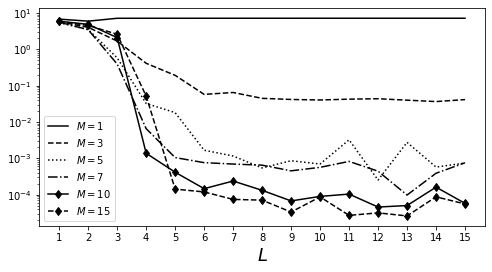

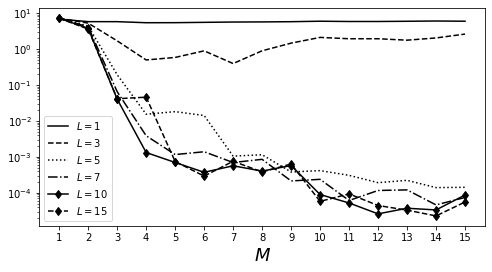

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_prop_cycle(MONOCHROME)
plot_depth_convergence(d, ax, subset=subset)
ax.legend()
ax.set_xlabel("$L$", fontsize=18)
savefig("curve-convergence-depth.pdf")

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_prop_cycle(MONOCHROME)
plot_width_convergence(d, ax, subset=subset)
ax.legend(loc=3)
ax.set_xlabel("$M$", fontsize=18)
savefig("curve-convergence-width.pdf")

plt.show()

## Surfaces

In [9]:
from funcshape.testlib.surfaces import RotationDiffeomorphism, HyperbolicParaboloid

In [10]:
# Analytic diffeomorphism
g = RotationDiffeomorphism()

# Define Curves 
f1 = HyperbolicParaboloid()
f0 = f1.compose(g)


num_layers_list = list(range(1, 16))
num_functions_list = list(range(1, 16))
subset = [1, 3, 5, 7, 10, 15]

d = create_convergence_dict(
    f0, f1, num_layers_list, num_functions_list, surface_reparametrization, transform="qmap", logger=Silent(), device="cuda")


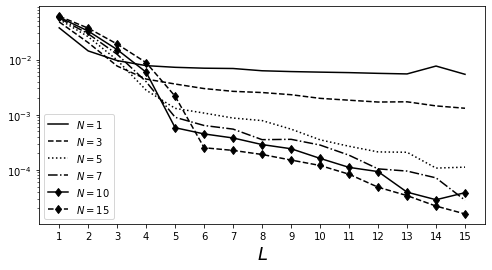

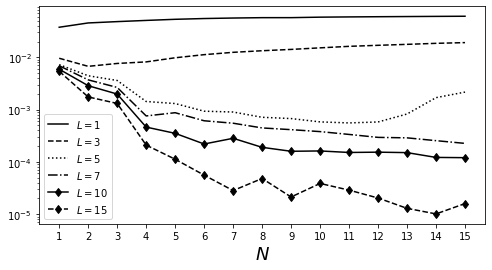

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_prop_cycle(MONOCHROME)
plot_depth_convergence(d, ax, subset=subset, label_identifier="N")
ax.legend(loc=3)
ax.set_xlabel("$L$", fontsize=18)
savefig("surface-convergence-depth.pdf")

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_prop_cycle(MONOCHROME)
plot_width_convergence(d, ax, subset=subset)
ax.legend(loc=3)
ax.set_xlabel("$N$", fontsize=18)
savefig("surface-convergence-width.pdf")

plt.show()